## Import Libaries

In [0]:
import pandas as pd
import numpy as np
import os
# Torch and Torchvision
import torchvision 
#from torch.utils import data
from torch.utils.data import Dataset, TensorDataset,DataLoader
from torchvision import datasets
import torchvision.transforms as transforms 
import matplotlib.pyplot as plt
from PIL import Image
import torch

In [0]:
!pip install tensorboardX
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorboardX import SummaryWriter
%load_ext tensorboard
import os
logs_base_dir = "Logs"
os.makedirs(logs_base_dir, exist_ok=True)
# debug ref: https://github.com/pytorch/pytorch/issues/22676

     |████████████████████████████████| 204kB 8.3MB/s 


## Data Preparation

### Load Data and check Meta info

In [0]:
transforms_raw = transforms.Compose([transforms.ToTensor()]) #for conversion to tensors
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transforms_raw)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transforms_raw)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
# get train, test set sizes
trainset_size =len(trainset) 
testset_size = len(testset)
print(trainset_size, testset_size)

50000 10000


In [0]:
#trainset.targets

In [0]:
# meta data information
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [0]:
# Calculate mean and std of the pixel values in images and nomalize it while transforming
x = np.concatenate([np.asarray(
    trainset[i][0].reshape(-1,
                             trainset[0][0].shape[0],
                             trainset[0][0].shape[1],
                             trainset[0][0].shape[2])
    ) for i in range(len(trainset))])
# print(x)
print(x.shape)

(50000, 3, 32, 32)


In [0]:
#trainset.data[0]
#trainset[0][0]

In [0]:
# calculate the mean and std along the (0, 1) axes
train_mean = np.mean(x, axis=(0,2,3))
train_std = np.std(x, axis=(0,2,3))
print(train_mean)
print(train_std)

[0.4914009  0.48215896 0.4465308 ]
[0.24703279 0.24348423 0.26158753]


### Filter 50% of the labels for training (bird, deer and truck)

In [0]:
# traning data labels for bird = 2, deer =4, truck = 9 need to be cut down to half 
custom_data=[]
custom_label =[]
bird = 0
deer =0
truck = 0
limit = 2500
for i in range(len(trainset)):#range(20):
    train_data_i = trainset[i][0]
    train_label_i = trainset[i][1]
    rules = [train_label_i == 0,
             train_label_i == 1,
             train_label_i == 3,
             train_label_i == 5,
             train_label_i == 6,
             train_label_i == 7,
             train_label_i == 8]
    if any(rules):
        custom_data.append(train_data_i)
        custom_label.append(train_label_i)      
    elif train_label_i==2:
      if bird<limit:
        bird+=1
        custom_data.append(train_data_i)
        custom_label.append(train_label_i)
    elif train_label_i==4:
      if deer<limit:
        deer+=1
        custom_data.append(train_data_i)
        custom_label.append(train_label_i)
    elif train_label_i==9:
      if truck<limit:
        truck+=1
        custom_data.append(train_data_i)
        custom_label.append(train_label_i)        


In [0]:
print(len(custom_data))
#tensor_clabel = torch.Tensor(custom_label)
#tensor_cdata = torch.Tensor(custom_data)

42500


In [0]:
print(len(custom_data))
tensor_clabel = custom_label
tensor_cdata = custom_data

42500


In [0]:
tensor_cdata[1]

tensor([[[0.6039, 0.4941, 0.4118,  ..., 0.3569, 0.3412, 0.3098],
         [0.5490, 0.5686, 0.4902,  ..., 0.3765, 0.3020, 0.2784],
         [0.5490, 0.5451, 0.4510,  ..., 0.3098, 0.2667, 0.2627],
         ...,
         [0.6863, 0.6118, 0.6039,  ..., 0.1647, 0.2392, 0.3647],
         [0.6471, 0.6118, 0.6235,  ..., 0.4039, 0.4824, 0.5137],
         [0.6392, 0.6196, 0.6392,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.6941, 0.5373, 0.4078,  ..., 0.3725, 0.3529, 0.3176],
         [0.6275, 0.6000, 0.4902,  ..., 0.3882, 0.3137, 0.2863],
         [0.6078, 0.5725, 0.4510,  ..., 0.3216, 0.2745, 0.2706],
         ...,
         [0.6549, 0.6039, 0.6275,  ..., 0.1333, 0.2078, 0.3255],
         [0.6039, 0.5961, 0.6314,  ..., 0.3647, 0.4471, 0.4745],
         [0.5804, 0.5804, 0.6118,  ..., 0.5216, 0.5255, 0.5216]],

        [[0.7333, 0.5333, 0.3725,  ..., 0.2784, 0.2784, 0.2745],
         [0.6627, 0.6039, 0.4627,  ..., 0.3059, 0.2431, 0.2392],
         [0.6431, 0.5843, 0.4392,  ..., 0.2510, 0.2157, 0.

In [0]:
#df = pd.DataFrame({'img_data':custom_data,'class_label':custom_label})
#df.iloc[1]['img_data'].shape
#df.to_csv('./data/xx.csv')
#ss = pd.read_csv('./data/xx.csv')

### Build Customed Dataset with Data Augumentation

In [0]:
# my_dataset = TensorDataset(tensor_cdata,tensor_clabel)
# ref:https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
# By default transforms are not supported for TensorDataset.
# but we want to use the the horizonalflip etc as data augumentation methods 
# Threfore we will create our custom class to add that option.
# ref: https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset
class CustomTensorDataset():
    """TensorDataset with support of transforms.
    """
    def __init__(self, images,labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        labels = self.labels[index]
        image_tensor = self.images[index]
        images = transforms.ToPILImage()(image_tensor)

        if self.transform:
            images = self.transform(images)


        return images, labels

    def __len__(self):
        return len(self.labels)

In [0]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.ToTensor(),
                                      transforms.Normalize(train_mean, train_std)
                                     ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(train_mean, train_std)
                                    ])

In [0]:
cifar10datasets = {
    'train':CustomTensorDataset(images=tensor_cdata,labels=tensor_clabel,
     transform=train_transform),
     'test':datasets.CIFAR10(
         root='./data', train=False, download=True, 
         transform=test_transform)
            }


Files already downloaded and verified


### Examples of Augmentation

To show how augmentation works, we will plot a tensor as an image and some examples of augmented result.

In [0]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for transformed Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array(train_mean)
    std = np.array(train_std)
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [0]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(2, 2))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

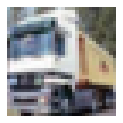

In [0]:
sample_img = np.array(custom_data[1]).transpose((1, 2, 0))
imshow(sample_img)

In [0]:

sample_img.shape

(32, 32, 3)

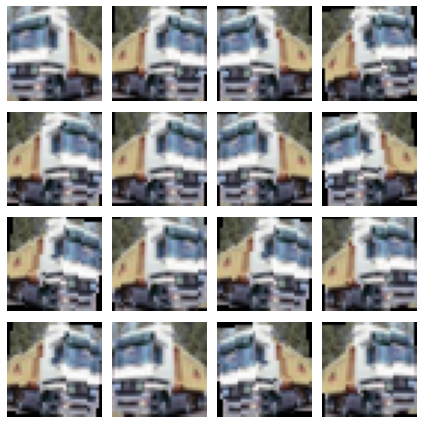

In [0]:
plt.figure(figsize=(6, 6))
sample_img = Image.fromarray((sample_img * 255).astype(np.uint8))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(train_transform(sample_img), ax=ax)

plt.tight_layout()

### Build  Data Iterators

 

To avoid loading all of the data into memory at once, we use training `DataLoaders`. First, we create a dataset object from the image folders, and then we pass these to a `DataLoader`. At training time, the `DataLoader` will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective `DataLoader`. 

One crucial aspect is to `shuffle` the data before passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch).

In [0]:
trainloader = DataLoader(cifar10datasets['train'], batch_size=16,shuffle=True, num_workers=2)
testloader = DataLoader(cifar10datasets['test'], batch_size=4,shuffle=True, num_workers=2)

In [0]:
#check The shape of a batch
trainiter = iter(trainloader)
a = next(trainiter)
print('batch shape', a[0].shape)

batch shape torch.Size([16, 3, 32, 32])


## Build&Train the Autoencoder Model


In [0]:
import torch.nn as nn # for Core neural network class in pytorch
import torch.optim as optim # for using the inbuilt pytorch optimzation functions
from torch.autograd import Variable 
import torch.nn.functional as F #for using different inbuilt functions of pytorch

# Torchvision
import torchvision 
from torchvision import datasets # for various datasets
import torchvision.transforms as transforms # for dataset transformation

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 # for image manipulation
#logger = Logger('./logs')
writer = SummaryWriter(logdir='Logs')

In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # TODO try 3*3 kernel 
        # Input size to the Autoencoder : [batch_size, 3, 32, 32]
        # Output size from the Autoencoder : [batch_size, 3, 32, 32]
        self.encoder = nn.Sequential(
            # 3 input channels(RGB), 12 output channels, 4x4 square convolution
            nn.Conv2d(in_channels = 3, out_channels = 12, kernel_size = 4, stride=2, padding=1), 
            nn.ReLU(),# Output size : [batch_size, 12, 16, 16]
            nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 4, stride=2, padding=1), 
            nn.ReLU(),# Output size : [batch_size, 24, 8, 8]
            nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = 4, stride=2, padding=1),
            nn.ReLU() 
            ## Output size : [batch_size, 48, 8, 8]
        )
        self.decoder = nn.Sequential(
          
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), # Output size: [batch_size, 24, 8, 8]
            nn.ReLU(),  
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), # Output size: [batch_size, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # Output size: [batch_size, 3, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [0]:
# moves variables to CUDA
def get_torch_vars(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return x

In [0]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
 
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)
    loss_store = []
    outputs_store = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs = get_torch_vars(inputs)

            # ============ Forward ============
            encoded, outputs = model(inputs)
            loss = criterion(outputs, inputs)
            
            # ============ Backward ============
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs_store.append((epoch, inputs, outputs),)
        loss_store.append(float(loss))
        # ================================================================== #
        #                        Tensorboard Logging                         #
        # ================================================================== #
        info = { 'loss': loss.item() }

        for tag, value in info.items():
            writer.add_scalar(tag, value, epoch+1)

        # 2. Log values and gradients of the parameters (histogram summary)
        for tag, value in model.named_parameters():
            tag = tag.replace('.', '/')
            writer.add_histogram(tag, value.data.cpu().numpy(), epoch+1)
            writer.add_histogram(tag+'/grad', value.grad.data.cpu().numpy(), epoch+1)
        # 3. Log training images (image summary)
        #info = { 'images': images.view(-1, 32, 32)[:10].cpu().numpy() }
        #
        #for tag, images in info.items():
        #    logger.image_summary(tag, images, epoch+1)
        writer.flush()
    print('Finished Training')
    print('Saving Model...')
    if not os.path.exists('./weights'):
        os.mkdir('./weights')
    #torch.save(model.state_dict(), "./weights/autoencoder.pkl")
    return model

In [0]:
def create_model():
    autoencoder = Autoencoder()
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
        print("Model moved to GPU.")
    return autoencoder

In [0]:
# Create model
autoencoder = create_model()
#train
max_epochs = 100
model = train(autoencoder, max_epochs)

==================== Encoder Network ====================
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)
==================== Decoder Network ====================
Sequential(
  (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): Sigmoid()
)


Model moved to GPU.
Epoch:1, Loss:0.4547
Epoch:2, Loss:0.9494
Epoch:3, Loss:0.6288
Epoch:4, Loss:0.5704
Epoch:5, Loss:0.7124
Epoch:6, Loss:0.8888
Epoch:7, Loss:0.7998
Epoch:8, Loss:0.5143
Epoch:9, Loss:0.3574
Epoch:10, Loss:0.7216
Epoch:11, Loss:0.4483
Epoch:12, Loss:0.8087
Epoch:13, Loss:0.7140
Epoch:1

## Visualization on test data

reconstruction


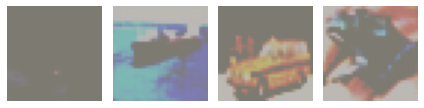

groundtruth


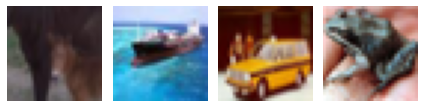

In [0]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for transformed Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    #image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array(train_mean)
    std = np.array(train_std)
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    plt.axis('off')

    return ax, image
output = model.cpu()(images)[1].detach()
print('reconstruction')
plt.figure(figsize=(6, 6))
for i in range(4):
    sample_img = (output[i].cpu().detach().numpy()).transpose(1, 2, 0)#Image.fromarray((outputs[i].cpu().detach().numpy() * 255).astype(np.uint8))
    ax = plt.subplot(1, 4, i + 1)
    _ = imshow_tensor(sample_img, ax=ax)

plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 6))
print('groundtruth')
for i in range(4):
    sample_img = (images[i].cpu().detach().numpy()).transpose(1, 2, 0)#Image.fromarray((outputs[i].cpu().detach().numpy() * 255).astype(np.uint8))
    ax = plt.subplot(1, 4, i + 1)
    _ = imshow_tensor(sample_img, ax=ax)

plt.tight_layout()
#imshow_tensor((outputs[i].cpu().detach().numpy()).transpose(1, 2, 0))

reconstruction


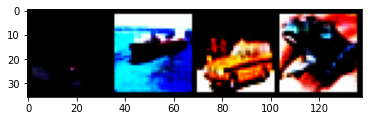

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ground truth


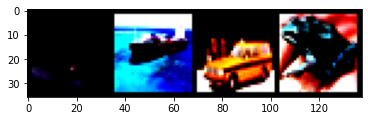

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print('reconstruction')
output = model.cpu()(images)[1].detach()
a= torchvision.utils.make_grid(output)
plt.imshow(a.permute(1, 2, 0))
plt.show()
print('ground truth')
a= torchvision.utils.make_grid(images)
plt.imshow(a.permute(1, 2, 0))
plt.show()

## Visulizing Tensorboard

In [0]:
#finally voila
#%tensorboard --logdir Logs

#http://hoolihan.net/blog-tim/2018/07/13/using-tensorboard-with-multiple-model-runs/

## Others

In [0]:
torch.save(outputs.state_dict(), "./weights/autoencoder-batch16-epoch100.pkl")